# 06_1 Klassifitseerimismudelid - logistiline regressioon_II_VER

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('toofailid/DATA_TEKSTIKOGU_puhastatud.xlsx', engine='openpyxl')
print(data.shape)

(636, 55)


In [3]:
data['Lahendi liik'].value_counts()

õigeksmõistev    350
tauniv           286
Name: Lahendi liik, dtype: int64

In [4]:
# Andmestiku segamine
#from sklearn.utils import shuffle
#data = shuffle(data)
#data = data.reset_index(drop=True)

In [5]:
# Ebavajaliku info  (aeg, pealkiri) eemaldamine
#data.drop(["date"],axis=1,inplace=True)
#data.drop(["title"],axis=1,inplace=True)
#data.drop(["subject"],axis=1,inplace=True)
#data.drop(["link"],axis=1,inplace=True)

In [6]:
#tekst_puhas = data['text_puhas'].to_list()
#tekst_tokenize = data['text_token'].to_list()
#tekst_lemmatize = data['text_lemmatize'].to_list()
#label = data['Lahendi liik'].to_list()

Stoppsõnadena on kasutusel sidesõnad ja sidesõnad koos asesõnadega.

In [7]:
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://www.taskutark.ee/m/asesonad/
#sidesõnad
stopsõnad = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']
#sidesõnad ja asesõnad
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju', '-']

# Veamaatriks, segadusmaatriks (confusion matrix)

In [8]:
# Veamaatriks (plot the confusion matrix)
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Veamaatriks',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normaliseeritud veamaatriks")
    else:
        print('Normaliseerimata veamaatriks')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('True label/Tõeline märgend')
    plt.xlabel('Predicted label/Prognoositud märgend')

### Logistiline regressioon (Logistic regression)

In [9]:
data.columns

Index(['#', 'title', 'text', 'Kaebuse kuupäev', 'Kaebuse aasta', 'Väljaanne',
       'Väljaande nimi1', 'Lingid', 'Lingid1', 'Dea_digar', 'Kaebuse sisu',
       'Lahendi tulemus1', 'Lahendi tulemus2', 'Lahendi kuupäev',
       'Otsuse sisu', 'Otsuse liik', 'Lahendi liik', 'Väljaande nimi',
       'Väljaande liik', 'Koodeks', '1.2', '1.4', '1.5', '1.6', '2.3', '3.1',
       '3.2', '3.3', '3.5', '3.6', '3.7', '4.1', '4.2', '4.3', '4.4', '4.6',
       '4.7', '4.8', '4.9', '4.10', '4.11', '4.12', '5.1', '5.2', '5.3', '6.1',
       'Koodeksipunkte', 'text_puhas', 'text_token', 'text_lemmatize', 'T1_4',
       'T4_1', 'T4_11', 'T_muu', 'ÕM'],
      dtype='object')

In [10]:
X, y = data['text_token'], data['Lahendi liik'] #sõnestatud tekst
#X, y = data['text_lemmatize'], data['Lahendi liik'] #lemmatiseeritud tekst

In [11]:
X

0      viimastel päevadel valitsenud külmalaine on ri...
1      tuntud ühiskonnategelane räägib et mõni piiran...
2      tahkuna uue elektrituuliku mittepüstitamine lä...
3      viiskümmend aastat tagasi sai tiit leito oma k...
4      tarbija esitas ttja-le kaebuse veskioja 1 oü n...
                             ...                        
631    kolm aastat pärast mait metsamaa surma on teda...
632    neeme järvi ligi kaks aastat tagasi maestro ne...
633    keskkonnainspektsiooni menetlus karepal selja ...
634    eesti kaubandusettevõtted üritavad raha kokku ...
635    võltsjuustude müügiga seostatavat estover-kaub...
Name: text_token, Length: 636, dtype: object

In [12]:
# Andmete tükeldamine treenimisandmestikuks ja testandmestikuks
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(508,) (128,) (508,) (128,)


In [14]:
X_train

31     kohus arutas põhjalikult kas fekaalidega määri...
427    kliendid leiavad et swedbank peaks võlgu tagas...
610    poliitikud peavad kahetsusväärseks olukorda ku...
499    selle loo ilmumise järel tuleb postimehel tõen...
105    patsient läheb ilukliinikusse suurte ootustega...
                             ...                        
198    kui edaspidi peaks keegi huvi tundma kust ma p...
93     koos kolme sõbrannaga möödunud neljapäeva õhtu...
54     metsatöösturid ja lageraiete vajalikkusest jut...
356    tundub et keskerakonnale on saanud iseenesestm...
489    kohtulugu • eile tartu ringkonnakohtus toimunu...
Name: text_token, Length: 508, dtype: object

In [15]:
# Read 15-17 ei saa aru, mida teevad. Minu meelest ei tööta õigesti.

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


skf =  StratifiedKFold(n_splits=2)
for train_index, val_index in skf.split(X_train, y_train):
    X_treen, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_treen, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    print(train_index)
    print(X_treen)
    print(val_index)
    print(X_val)
    

[239 241 242 245 247 248 256 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325
 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343
 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361
 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379
 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397
 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415
 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433
 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451
 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469
 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487
 488 489 490 491 492 493 494 495 496 497 498 499 50

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


skf =  StratifiedKFold(n_splits=3)

c_list = [0.1, 0.2, 0.5, 1, 2, 5, 5.5, 6, 10, 20, 50]
#c_list = [0.1, 0.5, 1, 2, 5, 5.5, 6]
mean_accuracy = []

for c in c_list:
    print("C väärtus: " + str(c))
    
    metrics = []

            
    for train_index, val_index in skf.split(X_train, y_train):
        X_treen, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_treen, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        

        pipe = Pipeline([('vect', CountVectorizer(min_df = 3, 
                                                  stop_words = stopsõnad_uus, 
                                                  max_df=0.85, 
                                                  ngram_range=(2,2))),
                       ('tfidf', TfidfTransformer(smooth_idf=True,
                                                  use_idf=True)),
                       ('model', LogisticRegression(C = c))])

        # Mudeli sobitamine
        model = pipe.fit(X_treen, y_treen)

        # Prognoosimine
        y_pred = model.predict(X_val)
      
        metrics.append(accuracy_score(y_val, y_pred))
        

        print(classification_report(y_val, y_pred, digits = 3))
        print('Confusion Matrix:',confusion_matrix(y_val, y_pred))
        
    metrics = np.array(metrics)
    print('Mean accuracy: ', np.mean(metrics, axis=0))
    mean_accuracy.append(np.mean(metrics, axis=0))
    print('Std for accuracy: ', np.std(metrics, axis=0))

C väärtus: 0.1


C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      1.000     0.026     0.051        76
õigeksmõistev      0.560     1.000     0.718        94

    micro avg      0.565     0.565     0.565       170
    macro avg      0.780     0.513     0.384       170
 weighted avg      0.756     0.565     0.420       170

Confusion Matrix: [[ 2 74]
 [ 0 94]]
               precision    recall  f1-score   support

       tauniv      1.000     0.026     0.051        76
õigeksmõistev      0.557     1.000     0.715        93

    micro avg      0.562     0.562     0.562       169
    macro avg      0.778     0.513     0.383       169
 weighted avg      0.756     0.562     0.417       169

Confusion Matrix: [[ 2 74]
 [ 0 93]]
               precision    recall  f1-score   support

       tauniv      1.000     0.013     0.026        76
õigeksmõistev      0.554     1.000     0.713        93

    micro avg      0.556     0.556     0.556       169
    macro avg      0.777     0.507    

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.750     0.079     0.143        76
õigeksmõistev      0.568     0.979     0.719        94

    micro avg      0.576     0.576     0.576       170
    macro avg      0.659     0.529     0.431       170
 weighted avg      0.649     0.576     0.461       170

Confusion Matrix: [[ 6 70]
 [ 2 92]]
               precision    recall  f1-score   support

       tauniv      1.000     0.079     0.146        76
õigeksmõistev      0.571     1.000     0.727        93

    micro avg      0.586     0.586     0.586       169
    macro avg      0.785     0.539     0.436       169
 weighted avg      0.764     0.586     0.466       169

Confusion Matrix: [[ 6 70]
 [ 0 93]]
               precision    recall  f1-score   support

       tauniv      1.000     0.092     0.169        76
õigeksmõistev      0.574     1.000     0.729        93

    micro avg      0.592     0.592     0.592       169
    macro avg      0.787     0.546    

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.867     0.171     0.286        76
õigeksmõistev      0.594     0.979     0.739        94

    micro avg      0.618     0.618     0.618       170
    macro avg      0.730     0.575     0.512       170
 weighted avg      0.716     0.618     0.536       170

Confusion Matrix: [[13 63]
 [ 2 92]]
               precision    recall  f1-score   support

       tauniv      0.944     0.224     0.362        76
õigeksmõistev      0.609     0.989     0.754        93

    micro avg      0.645     0.645     0.645       169
    macro avg      0.777     0.606     0.558       169
 weighted avg      0.760     0.645     0.578       169

Confusion Matrix: [[17 59]
 [ 1 92]]
               precision    recall  f1-score   support

       tauniv      0.938     0.197     0.326        76
õigeksmõistev      0.601     0.989     0.748        93

    micro avg      0.633     0.633     0.633       169
    macro avg      0.769     0.593    

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.739     0.224     0.343        76
õigeksmõistev      0.599     0.936     0.730        94

    micro avg      0.618     0.618     0.618       170
    macro avg      0.669     0.580     0.537       170
 weighted avg      0.661     0.618     0.557       170

Confusion Matrix: [[17 59]
 [ 6 88]]
               precision    recall  f1-score   support

       tauniv      0.771     0.355     0.486        76
õigeksmõistev      0.634     0.914     0.749        93

    micro avg      0.663     0.663     0.663       169
    macro avg      0.703     0.635     0.618       169
 weighted avg      0.696     0.663     0.631       169

Confusion Matrix: [[27 49]
 [ 8 85]]
               precision    recall  f1-score   support

       tauniv      0.815     0.289     0.427        76
õigeksmõistev      0.620     0.946     0.749        93

    micro avg      0.651     0.651     0.651       169
    macro avg      0.717     0.618    

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.788     0.342     0.477        76
õigeksmõistev      0.635     0.926     0.753        94

    micro avg      0.665     0.665     0.665       170
    macro avg      0.711     0.634     0.615       170
 weighted avg      0.703     0.665     0.630       170

Confusion Matrix: [[26 50]
 [ 7 87]]
               precision    recall  f1-score   support

       tauniv      0.638     0.487     0.552        76
õigeksmõistev      0.649     0.774     0.706        93

    micro avg      0.645     0.645     0.645       169
    macro avg      0.643     0.631     0.629       169
 weighted avg      0.644     0.645     0.637       169

Confusion Matrix: [[37 39]
 [21 72]]
               precision    recall  f1-score   support

       tauniv      0.628     0.355     0.454        76
õigeksmõistev      0.611     0.828     0.703        93

    micro avg      0.615     0.615     0.615       169
    macro avg      0.620     0.592    

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.636     0.368     0.467        76
õigeksmõistev      0.619     0.830     0.709        94

    micro avg      0.624     0.624     0.624       170
    macro avg      0.628     0.599     0.588       170
 weighted avg      0.627     0.624     0.601       170

Confusion Matrix: [[28 48]
 [16 78]]
               precision    recall  f1-score   support

       tauniv      0.609     0.513     0.557        76
õigeksmõistev      0.648     0.731     0.687        93

    micro avg      0.633     0.633     0.633       169
    macro avg      0.628     0.622     0.622       169
 weighted avg      0.630     0.633     0.629       169

Confusion Matrix: [[39 37]
 [25 68]]
               precision    recall  f1-score   support

       tauniv      0.604     0.382     0.468        76
õigeksmõistev      0.612     0.796     0.692        93

    micro avg      0.609     0.609     0.609       169
    macro avg      0.608     0.589    

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.622     0.368     0.463        76
õigeksmõistev      0.616     0.819     0.703        94

    micro avg      0.618     0.618     0.618       170
    macro avg      0.619     0.594     0.583       170
 weighted avg      0.619     0.618     0.596       170

Confusion Matrix: [[28 48]
 [17 77]]
               precision    recall  f1-score   support

       tauniv      0.609     0.513     0.557        76
õigeksmõistev      0.648     0.731     0.687        93

    micro avg      0.633     0.633     0.633       169
    macro avg      0.628     0.622     0.622       169
 weighted avg      0.630     0.633     0.629       169

Confusion Matrix: [[39 37]
 [25 68]]
               precision    recall  f1-score   support

       tauniv      0.620     0.408     0.492        76
õigeksmõistev      0.622     0.796     0.698        93

    micro avg      0.621     0.621     0.621       169
    macro avg      0.621     0.602    

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.622     0.368     0.463        76
õigeksmõistev      0.616     0.819     0.703        94

    micro avg      0.618     0.618     0.618       170
    macro avg      0.619     0.594     0.583       170
 weighted avg      0.619     0.618     0.596       170

Confusion Matrix: [[28 48]
 [17 77]]
               precision    recall  f1-score   support

       tauniv      0.600     0.513     0.553        76
õigeksmõistev      0.644     0.720     0.680        93

    micro avg      0.627     0.627     0.627       169
    macro avg      0.622     0.617     0.617       169
 weighted avg      0.624     0.627     0.623       169

Confusion Matrix: [[39 37]
 [26 67]]
               precision    recall  f1-score   support

       tauniv      0.585     0.408     0.481        76
õigeksmõistev      0.612     0.763     0.679        93

    micro avg      0.604     0.604     0.604       169
    macro avg      0.598     0.586    

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.592     0.382     0.464        76
õigeksmõistev      0.612     0.787     0.688        94

    micro avg      0.606     0.606     0.606       170
    macro avg      0.602     0.584     0.576       170
 weighted avg      0.603     0.606     0.588       170

Confusion Matrix: [[29 47]
 [20 74]]
               precision    recall  f1-score   support

       tauniv      0.606     0.526     0.563        76
õigeksmõistev      0.650     0.720     0.684        93

    micro avg      0.633     0.633     0.633       169
    macro avg      0.628     0.623     0.624       169
 weighted avg      0.631     0.633     0.630       169

Confusion Matrix: [[40 36]
 [26 67]]
               precision    recall  f1-score   support

       tauniv      0.593     0.421     0.492        76
õigeksmõistev      0.617     0.763     0.683        93

    micro avg      0.609     0.609     0.609       169
    macro avg      0.605     0.592    

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.547     0.382     0.450        76
õigeksmõistev      0.598     0.745     0.664        94

    micro avg      0.582     0.582     0.582       170
    macro avg      0.573     0.563     0.557       170
 weighted avg      0.575     0.582     0.568       170

Confusion Matrix: [[29 47]
 [24 70]]
               precision    recall  f1-score   support

       tauniv      0.600     0.553     0.575        76
õigeksmõistev      0.657     0.699     0.677        93

    micro avg      0.633     0.633     0.633       169
    macro avg      0.628     0.626     0.626       169
 weighted avg      0.631     0.633     0.631       169

Confusion Matrix: [[42 34]
 [28 65]]
               precision    recall  f1-score   support

       tauniv      0.579     0.434     0.496        76
õigeksmõistev      0.616     0.742     0.673        93

    micro avg      0.604     0.604     0.604       169
    macro avg      0.598     0.588    

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\linear_model\logistic.py:436: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


               precision    recall  f1-score   support

       tauniv      0.569     0.382     0.457        76
õigeksmõistev      0.605     0.766     0.676        94

    micro avg      0.594     0.594     0.594       170
    macro avg      0.587     0.574     0.566       170
 weighted avg      0.589     0.594     0.578       170

Confusion Matrix: [[29 47]
 [22 72]]
               precision    recall  f1-score   support

       tauniv      0.600     0.553     0.575        76
õigeksmõistev      0.657     0.699     0.677        93

    micro avg      0.633     0.633     0.633       169
    macro avg      0.628     0.626     0.626       169
 weighted avg      0.631     0.633     0.631       169

Confusion Matrix: [[42 34]
 [28 65]]
               precision    recall  f1-score   support

       tauniv      0.596     0.447     0.511        76
õigeksmõistev      0.625     0.753     0.683        93

    micro avg      0.615     0.615     0.615       169
    macro avg      0.611     0.600    

In [17]:
for i in range(len(c_list)):
    print(str(c_list[i]) + '\t ' + str(mean_accuracy[i]))

0.1	 0.5610163592064045
0.2	 0.5846617937115673
0.5	 0.6319178558997564
1	 0.6437521754263836
2	 0.6416869706462466
5	 0.6220443206868546
5.5	 0.6240283095486715
6	 0.6161387631975868
10	 0.6161619677456781
20	 0.606346443903005
50	 0.6142127857059984


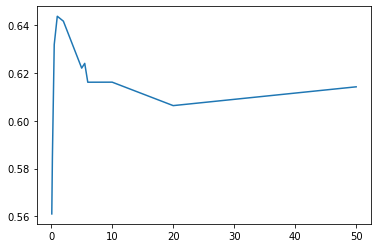

In [18]:
plt.plot(c_list, mean_accuracy)